<h1> Shor's Algorithm </h1>

Shor's algorithm provides a polynomial time quantum algorithm for the factoring problem. Best known classical algorithm for factorizing integers is of exponential time.

$\newcommand{\Mod}[1]{\ (\mathrm{mod}\ #1)}$
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\dot}[2]{ #1 \cdot #2} $
$ \newcommand{\biginner}[2]{\left\langle #1,#2\right\rangle} $
$ \newcommand{\mymatrix}[2]{\left( \begin{array}{#1} #2\end{array} \right)} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $
$ \newcommand{\myrvector}[1]{\mymatrix{r}{#1}} $
$ \newcommand{\mypar}[1]{\left( #1 \right)} $
$ \newcommand{\mybigpar}[1]{ \Big( #1 \Big)} $
$ \newcommand{\sqrttwo}{\frac{1}{\sqrt{2}}} $
$ \newcommand{\dsqrttwo}{\dfrac{1}{\sqrt{2}}} $
$ \newcommand{\onehalf}{\frac{1}{2}} $
$ \newcommand{\donehalf}{\dfrac{1}{2}} $
$ \newcommand{\hadamard}{ \mymatrix{rr}{ \sqrttwo & \sqrttwo \\ \sqrttwo & -\sqrttwo }} $
$ \newcommand{\vzero}{\myvector{1\\0}} $
$ \newcommand{\vone}{\myvector{0\\1}} $
$ \newcommand{\stateplus}{\myvector{ \sqrttwo \\  \sqrttwo } } $
$ \newcommand{\stateminus}{ \myrvector{ \sqrttwo \\ -\sqrttwo } } $
$ \newcommand{\myarray}[2]{ \begin{array}{#1}#2\end{array}} $
$ \newcommand{\X}{ \mymatrix{cc}{0 & 1 \\ 1 & 0}  } $
$ \newcommand{\Z}{ \mymatrix{rr}{1 & 0 \\ 0 & -1}  } $
$ \newcommand{\Htwo}{ \mymatrix{rrrr}{ \frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} } } $
$ \newcommand{\CNOT}{ \mymatrix{cccc}{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0} } $
$ \newcommand{\norm}[1]{ \left\lVert #1 \right\rVert } $
$ \newcommand{\pstate}[1]{ \lceil \mspace{-1mu} #1 \mspace{-1.5mu} \rfloor } $

<h2>Problem Definition</h2>

Given a positive integer $N$, what prime numbers when multiplied together equal to $N$? 

<h2>Quantum Fourier Transform Circuit</h2>

We are going to use two gates: Hadamard and controlled rotation gate.

$$ CR_k = \mymatrix{cccc}{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{\frac{2\pi i}{2^{k}}} }  $$

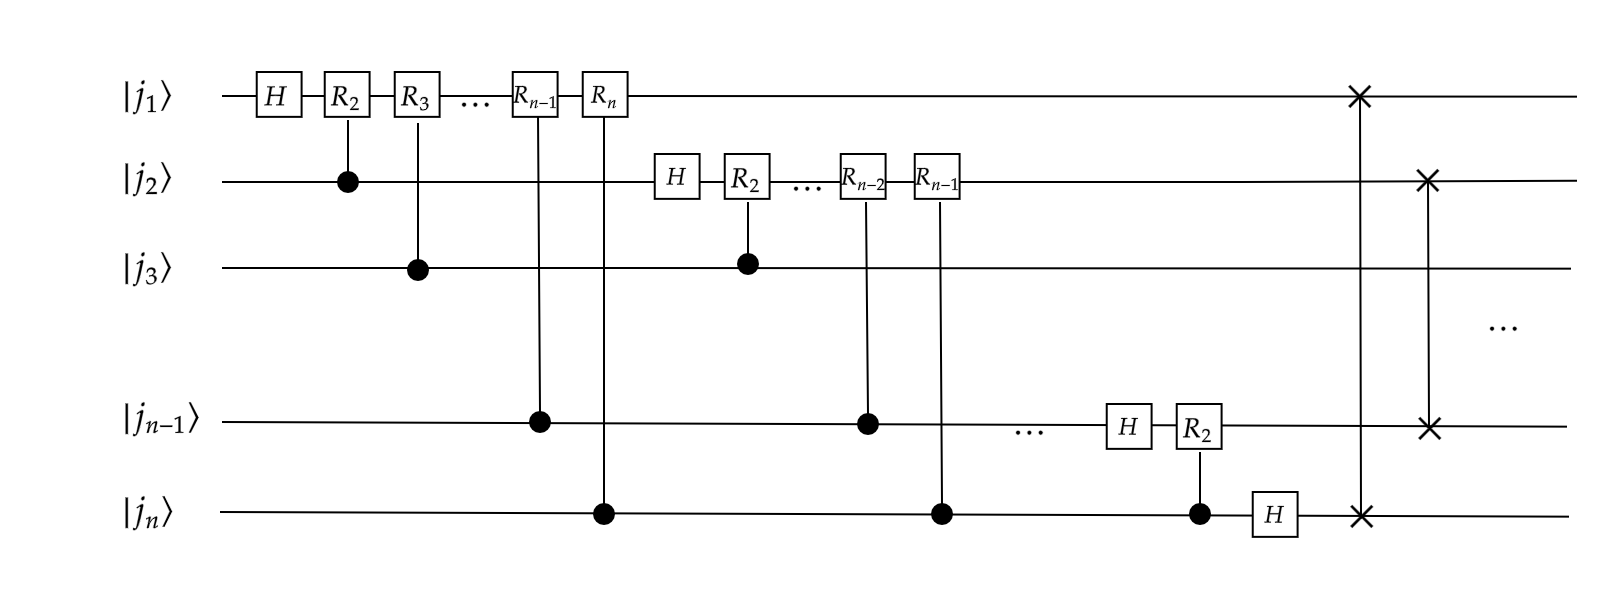

Now we are ready to implement our circuit in Cirq. To implement $CR_k$, we will use the $CZPowGate(exponent=t)$.

By letting $t=2/2^k$ we can create the gate $CR_k$.

<h2>Phase estimation circuit</h2>

We will examine the effect of applying a series of controlled $ U $ operators. Let $ U $ be an operator with eigenvector $ \ket{\psi} $ and the corresponding eigenvalue $ e^{2\pi i \phi } $.

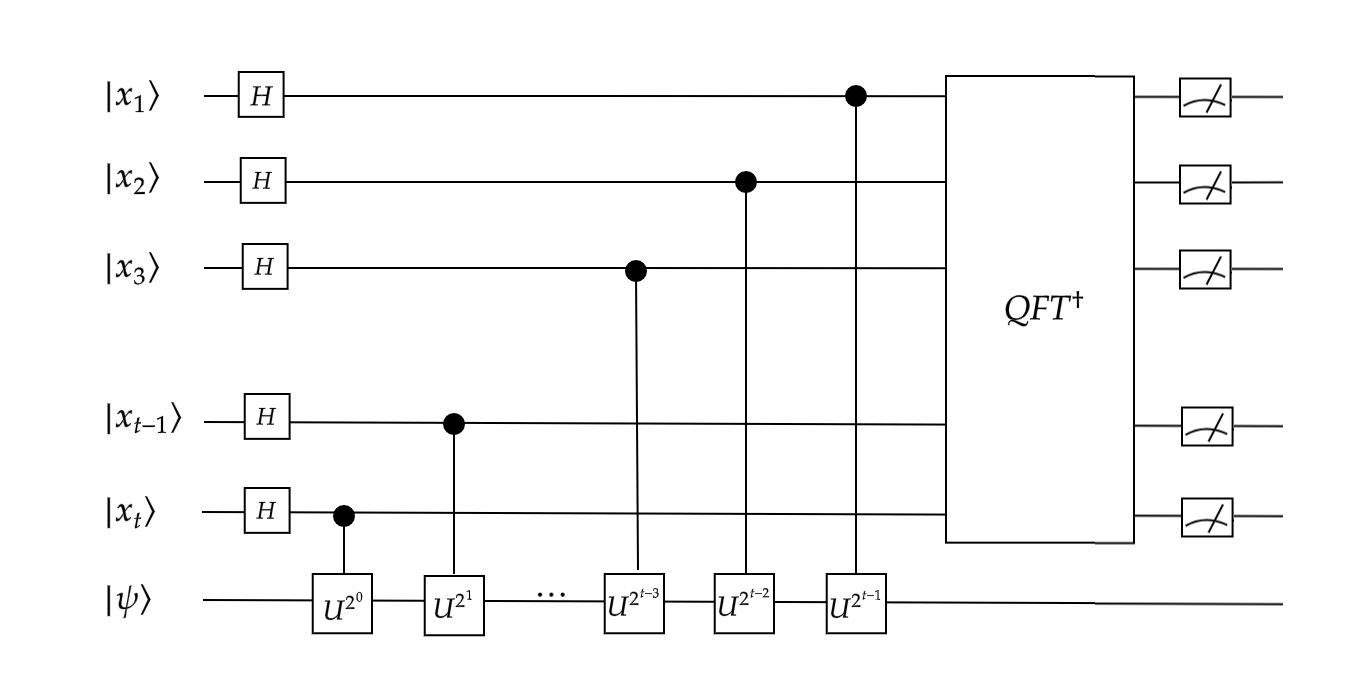

We start with the initial state $ \ket{0}^{\otimes t}\ket{\psi}$.

After applying Hadamard to first register we get $ \displaystyle \frac{1}{2^{t/2}} \sum_{k=0}^{2^t-1} \ket{k}\ket{\psi}  $.

Let $ k=k_1 ... k_t $ be the state of the first register. Let's apply the first controlled gate, $ CU^{2^0} $ where qubit $t$ is the control.
	
If $ k_t=0 $, new state is  $\ket{k} \ket{\psi} $. If $ k_t=1 $, new state is $ e^{2\pi i \phi 2^0} \ket{k} \ket{\psi} $. 

Hence, we can write it as, $\ket{k} U^{k_t 2 ^0} \ket{\psi}.$

***

<h2>Algorithm</h2>

- Pick $x$ randomly in the range $1$ to $N-1$, such that $gcd(x,N)=1$.
- Use order finding algorithm to find order of $x\Mod{N}$, which will be denoted by $r$.
- If $r$ is even, and $x^{r/2} \neq -1 \Mod{N}$, then compute $gcd(x^{r/2} -1, N)$ and  $gcd(x^{r/2}+1, N)$.
- Test to see if one of these is a non-trivial factor. If so return, otherwise the algorithm fails. If that is the case, repeat.

In [1]:
# The number to be factorized
N = 21

In [2]:
# Pick a random x relatively prime with N, such that gcd(x,N)=1:

import numpy as np
import random

counter = 0

while True:
    x = random.randrange(1,N)
    counter += 1
    if np.gcd(x,N) == 1:
        break

print(x, " is picked after ",counter, "trials.")


13  is picked after  2 trials.


In [3]:
# Define a function Ux to implement CU operator which used in
# order phase estimation to find order of x(mod N)

import cirq
import numpy as np

def Ux(x,N):
    
    k=1 
    while N>2**k:
        k +=1

    u = np.zeros([2**k, 2**k], dtype = int)
    
    for i in range(N):
        u[(x*i)%N][i]=1
    
    for i in range(N, 2**k):
        u[i][i]=1
    
    UX = cirq.MatrixGate(u).controlled()
    return UX

# Create CU operator by calling function Ux(x,N):
CU = Ux(x,N)

In [4]:
# Define the Inverse Quantum Fourier Transform circuit:

import cirq
from cirq.circuits import InsertStrategy
from cirq import H, SWAP, CZPowGate

def iqft(n, qubits, circuit):
    
    # Swap the qubits:
    for i in range(n//2):
        circuit.append(SWAP(qubits[i], qubits[n-i-1]), strategy = InsertStrategy.NEW)

    # For each qubit:
    for i in range(n-1, -1, -1):
        
        # Apply CR_k gates where j is the control and i is the target
        k = n-i    # We start wit k=n-i
        for j in range(n-1, i, -1):
            # Define apply CR_k gate:
            CRk = CZPowGate(exponent = -2/2**k)
            circuit.append(CRk(qubits[j], qubits[i]), strategy = InsertStrategy.NEW)
            k -= 1    # Decrement at each step
        
        # Apply Hadamard gate to the qubit:
        circuit.append(H(qubits[i]), strategy = InsertStrategy.NEW)

In [5]:
# Define the Quantum Phase Estimation Circuit:

import cirq

def qpe(t, control, target, circuit, CU):
    
    # Apply Hadamard to control qubits:
    circuit.append(cirq.H.on_each(control))
    
    # Apply CU gates:
    for i in range(t):
        # Obtain the power of CU gate:
        CUi = CU**(2**i)
        # Apply CUi gate t-i-1 is the control:
        circuit.append(CUi(control[t-i-1], *target))
    
    # Apply inverse QFT
    iqft(t, control, circuit)

In [6]:
# Determine t and n, size of the control and target registers:

from math import log2, ceil

n = ceil(log2(N))    # Size of target register
t = 2*n + 1 + ceil(log2(2+ 1/(2*0.1)))    # Size of control register

In [7]:
print(f"""N = {N}
x = {x}
n = {n}
t = {t}
""")

N = 21
x = 13
n = 5
t = 14



In [8]:
from cirq import X
import matplotlib as plt

# Create control and target qubits and the circuit

circuit = cirq.Circuit()

control = [cirq.LineQubit(i) for i in range(1, t+1)]
target = [cirq.LineQubit(i) for i in range(t+1, t+1+n)]

circuit.append(X(target[n-1]))

# Call phase estimation circuit with parameter CU
qpe(t, control, target, circuit, CU)

# Measure the control register
circuit.append(cirq.measure(*control, key='result'))

In [9]:
# Call the simulator and print the result
simulator = cirq.Simulator()
results = simulator.simulate(circuit)
print(results)

measurements: result=10000000000000

qubits: (cirq.LineQubit(1),)
output vector: |1⟩

qubits: (cirq.LineQubit(2),)
output vector: |0⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

qubits: (cirq.LineQubit(4),)
output vector: |0⟩

qubits: (cirq.LineQubit(5),)
output vector: |0⟩

qubits: (cirq.LineQubit(6),)
output vector: |0⟩

qubits: (cirq.LineQubit(7),)
output vector: |0⟩

qubits: (cirq.LineQubit(8),)
output vector: |0⟩

qubits: (cirq.LineQubit(9),)
output vector: |0⟩

qubits: (cirq.LineQubit(10),)
output vector: |0⟩

qubits: (cirq.LineQubit(11),)
output vector: |0⟩

qubits: (cirq.LineQubit(12),)
output vector: |0⟩

qubits: (cirq.LineQubit(13),)
output vector: |0⟩

qubits: (cirq.LineQubit(14),)
output vector: |0⟩

qubits: (cirq.LineQubit(15), cirq.LineQubit(16), cirq.LineQubit(17), cirq.LineQubit(18), cirq.LineQubit(19))
output vector: 0.707|00001⟩ - 0.707|01101⟩

phase:
output vector: |⟩


In [10]:
binary = results.measurements['result']
decimal = int("".join(str(i) for i in binary), 2)
print(decimal)

8192


In [11]:
# Define the continued Fraction and convergents functions:
from math import ceil
from fractions import Fraction

def contFrac(N):
    cf = []
    while True:
        cf.append(int(N))
        f = N - N//1
        if f < 0.0001:    # Precision must be considered close enough to 0
            break
        
        N = 1/f
        
        if ceil(N)-N < 0.0001:
            N = round(N)
            
    return cf

def convergents(cf):
    c = []
    cv = []
    
    for i in range(len(cf)):
        c.append(cf[i])
        for j in range(i-1, -1, -1):
            c[i] = 1/c[i] + cf[j]
        cv.append(Fraction(c[i]).limit_denominator(10000))
    
    return cv


# Run continued fractions algorithm to find out r:
cf = contFrac(decimal/(2**t))
print(cf)
cv = convergents(cf)
print(cv)

[0, 2]
[Fraction(0, 1), Fraction(1, 2)]


***
__Stop here and take the results!__

The candidate is $s'=1$ and $r'=2$.

In [14]:
# Chech if r is even, and (x^{r/2} Mod N) is not equal to -1 

r = 2
if r % 2 == 0 and x**(r/2) % N != -1:
    print("Proceed")
else:
    print("Repeat the algorithm")

Proceed


In [15]:
# Import the Greatest common divisor funtion:
from numpy import gcd

# Calculate the factors:
f1 = gcd((x**int(r/2)-1), N)
f2 = gcd((x**int(r/2)+1), N)

# Print the factors of the given no. (N):
print(f"Factors of {N}: {f1} and {f2}.")

Factors of 21: 3 and 7.
